In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Memoria GPU configurada correctamente")
    except RuntimeError as e:
        print(e)

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Memoria GPU configurada correctamente


In [2]:
# =============================================================
# Notebook 12 — Evaluación del modelo U-Net
# =============================================================

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [3]:
# =============================================================
# 1. Definir métricas personalizadas
# =============================================================

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + (1 - dice_coef(y_true, y_pred))

In [4]:
# =============================================================
# 2. Cargar modelo U-Net
# =============================================================

MODEL_PATH = "unet_final_model.h5"

model = load_model(
    MODEL_PATH,
    custom_objects={
        "dice_coef": dice_coef,
        "bce_dice_loss": bce_dice_loss
    }
)

print("Modelo U-Net cargado correctamente.\n")

Modelo U-Net cargado correctamente.



In [5]:
# =============================================================
# 3. Cargar dataset de test
# =============================================================

BASE_IMG = r"../data/processed"
BASE_MASK = r"../data/masks_manual_bin"

test_df = pd.read_csv("test_split.csv")
print(test_df.head())

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 127).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

def load_pair(img_path, mask_path):
    img = load_image(img_path.numpy().decode())
    mask = load_mask(mask_path.numpy().decode())
    return img, mask

def tf_wrapper(img_path, mask_path):
    img, mask = tf.py_function(
        load_pair,
        [img_path, mask_path],
        [tf.float32, tf.float32]
    )
    img.set_shape([384, 384, 1])
    mask.set_shape([384, 384, 1])
    return img, mask

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["img"].values, test_df["mask"].values)
)

test_ds = test_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(4).prefetch(tf.data.AUTOTUNE)

print("Dataset de test preparado.\n")

                                                 img  \
0  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
1  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
2  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
3  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
4  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   

                                                mask       center  
0  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Goya_Madrid  
1  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...    Barcelona  
2  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Goya_Madrid  
3  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Guadalajara  
4  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...       Getafe  
Dataset de test preparado.



In [6]:
# =============================================================
# 4. Evaluación global (Dice, IoU)
# =============================================================

def compute_metrics(model, dataset):
    dices = []
    ious = []

    for batch_imgs, batch_masks in dataset:
        preds = model.predict(batch_imgs)
        preds_bin = (preds > 0.5).astype(np.float32)

        for p, m in zip(preds_bin, batch_masks.numpy()):
            intersection = np.sum(p * m)
            union = np.sum(p) + np.sum(m)

            dice = (2 * intersection) / (union + 1e-6)
            iou = intersection / (union - intersection + 1e-6)

            dices.append(dice)
            ious.append(iou)

    return np.mean(dices), np.mean(ious)

dice_mean, iou_mean = compute_metrics(model, test_ds)

print("===== RESULTADOS U-NET =====")
print(f"Dice medio: {dice_mean:.4f}")
print(f"IoU medio : {iou_mean:.4f}\n")

1/1 [==============================] - 0s 158ms/step
===== RESULTADOS U-NET =====
Dice medio: 0.8892
IoU medio : 0.8129



In [7]:
# =============================================================
# 5. Evaluación por centro
# =============================================================

def df_to_dataset(df):
    ds = tf.data.Dataset.from_tensor_slices((df["img"], df["mask"]))
    ds = ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(1)
    return ds

dice_center = {}

for center in test_df["center"].unique():
    sub = test_df[test_df["center"] == center]
    ds = df_to_dataset(sub)

    scores = []
    for img, mask in ds:
        pred = model.predict(img)[0, ..., 0]
        pred_bin = (pred > 0.5).astype(np.float32)

        m = mask.numpy().squeeze()

        inter = np.sum(pred_bin * m)
        union = np.sum(pred_bin) + np.sum(m)
        dice = (2 * inter) / (union + 1e-6)
        scores.append(dice)

    dice_center[center] = np.mean(scores)

print("===== DICE POR CENTRO (U-NET) =====")
for c, v in dice_center.items():
    print(f"{c}: {v:.4f}")

1/1 [==============================] - 0s 22ms/step
===== DICE POR CENTRO (U-NET) =====
Goya_Madrid: 0.9290
Barcelona: 0.9160
Guadalajara: 0.8802
Getafe: 0.9358
Albacete: 0.8835
Navarra: 0.8478
Salamanca: 0.9277
Caceres: 0.8299
La_Paz: 0.8479


In [8]:
# =============================================================
# 6. Métricas por imagen + Guardado CSV
# =============================================================

def compute_image_metrics(model, df):
    results = []

    for idx, row in df.iterrows():
        img = load_image(row["img"])
        mask = load_mask(row["mask"])

        pred = model.predict(img[None, ...])[0, ..., 0]
        pred_bin = (pred > 0.5).astype(np.float32)

        m = mask[..., 0]

        TP = np.sum((pred_bin == 1) & (m == 1))
        TN = np.sum((pred_bin == 0) & (m == 0))
        FP = np.sum((pred_bin == 1) & (m == 0))
        FN = np.sum((pred_bin == 0) & (m == 1))

        dice = (2 * TP) / (2 * TP + FP + FN + 1e-6)
        iou = TP / (TP + FP + FN + 1e-6)
        sensitivity = TP / (TP + FN + 1e-6)
        specificity = TN / (TN + FP + 1e-6)

        results.append({
            "center": row["center"],
            "img": row["img"],
            "dice": dice,
            "iou": iou,
            "sensitivity": sensitivity,
            "specificity": specificity,
        })

    return pd.DataFrame(results)

print("\nCalculando métricas detalladas por imagen (U-Net)...")
df_results_unet = compute_image_metrics(model, test_df)

df_results_unet.to_csv("Resultados Modelos/unet_results.csv", index=False)
print("CSV generado: unet_results.csv")


Calculando métricas detalladas por imagen (U-Net)...
1/1 [==============================] - 0s 22ms/step
CSV generado: unet_results.csv


In [9]:
# =============================================================
# 7. Guardar CSV por centro
# =============================================================

df_center_unet = df_results_unet.groupby("center").agg({
    "dice": "mean",
    "iou": "mean",
    "sensitivity": "mean",
    "specificity": "mean"
}).reset_index()

df_center_unet.to_csv("Resultados Modelos/unet_results_by_center.csv", index=False)
print("CSV generado: unet_results_by_center.csv\n")

df_center_unet

CSV generado: unet_results_by_center.csv



,center,dice,iou,sensitivity,specificity
0,Albacete,0.883489,0.798944,0.897054,0.982038
1,Barcelona,0.916038,0.848650,0.890899,0.992747
2,Caceres,0.829888,0.753606,0.802094,0.990607
3,Getafe,0.935839,0.881508,0.947451,0.989606
4,Goya_Madrid,0.928974,0.869911,0.947844,0.986534
5,Guadalajara,0.880190,0.792304,0.961906,0.978268
6,La_Paz,0.847876,0.750239,0.815226,0.987347
7,Navarra,0.847794,0.753273,0.854015,0.980054
8,Salamanca,0.927700,0.867006,0.907029,0.994155


1/1 [==============================] - 0s 23ms/step


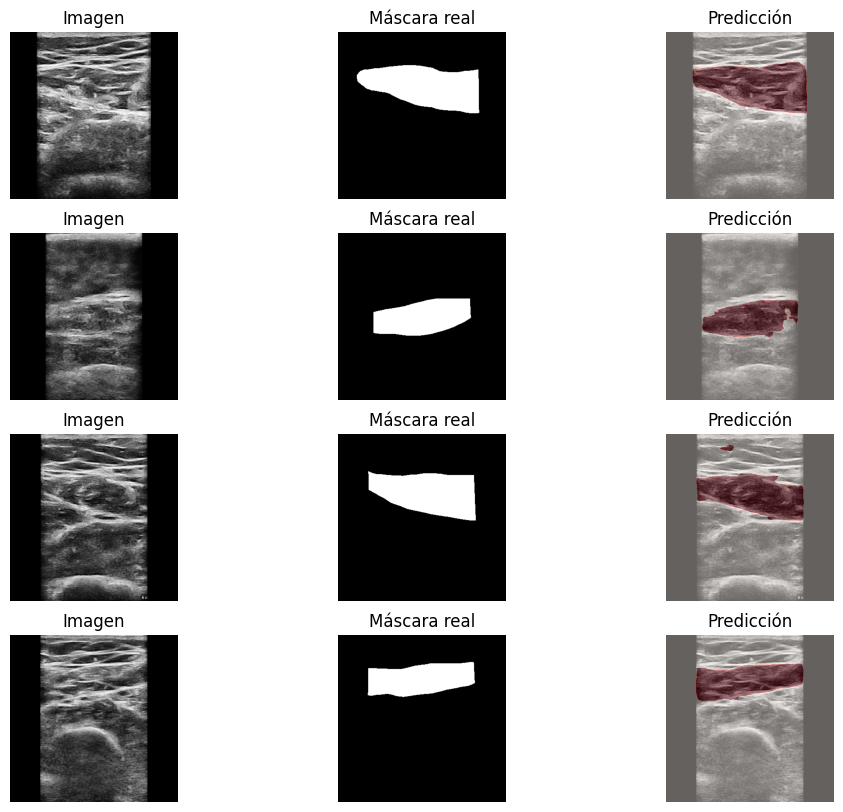

In [10]:
#. Visualización cualitativa
def show_prediction(model, dataset, n=4):
    batch = next(iter(dataset))
    imgs, masks = batch

    preds = model.predict(imgs)
    preds_bin = (preds > 0.5).astype(np.float32)

    plt.figure(figsize=(12, 10))

    for i in range(n):
        plt.subplot(n, 3, 3*i+1)
        plt.imshow(imgs[i,...,0], cmap='gray')
        plt.title("Imagen")
        plt.axis("off")

        plt.subplot(n, 3, 3*i+2)
        plt.imshow(masks[i,...,0], cmap='gray')
        plt.title("Máscara real")
        plt.axis("off")

        plt.subplot(n, 3, 3*i+3)
        plt.imshow(imgs[i,...,0], cmap='gray')
        plt.imshow(preds_bin[i,...,0], cmap='Reds', alpha=0.4)
        plt.title("Predicción")
        plt.axis("off")

show_prediction(model, test_ds, n=4)